# Part 2 details running the models for classification (random forests and logistic regression) through the lens of usertype

### *Note we also applied same process to Gender (male=1, female =0) and millenials (born_after_1983=1, born_before_1983=0) however accuracy was only about 50% - 53%. No better than flipping a coin so I decided not to put them in

## Classifying Usertype by logistic regression and random forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
from scipy import stats
import seaborn as sns
import datetime as dt
import calendar

%matplotlib inline


bikenyc = pd.read_csv("C:/Users/Monchita/Desktop/Final proj/NYCreal/bike_no_outliers.csv")

bikenyc[['starttime','stoptime']] = bikenyc[['starttime','stoptime']].apply(pd.to_datetime)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 40)

### Handling a severely imbalanced class by downsampling it

In [2]:
#Checking to see usertype - how many should i downsample considering subsriber is 94%???
print (bikenyc.shape)
print (bikenyc[(bikenyc['Subscriber']==1)].shape)
print (bikenyc[(bikenyc['Customer']==1)].shape)

(4393060, 36)
(4166474, 36)
(226586, 36)


In [3]:
#Trying to handle imbalanced classes
#Downsampling the dataset - removed 3,916,474 entries

bike_user_downsample = bikenyc[(bikenyc['Subscriber']==1)]

bike_user_down=bike_user_downsample.sample(n=250000,random_state=42)

bike_customer = bikenyc[(bikenyc['Customer']==1)]

ds = [bike_user_down,bike_customer]
bike_ds = pd.concat(ds)

bike_ds.shape

(476586, 36)

In [4]:
bike_ds.head()

,starttime,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,tripduration_minutes,Customer,Subscriber,Gender_unknown,Gender_male,Gender_female,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,holiday,weekend,workday,rushmorning_all,rushmorning_workday,rushevening_all,rushevening_workday,millenial
3471733,2018-11-05 13:11:06.994,1081,2018-11-05 13:29:08.546,401.0,Allen St & Rivington St,40.720196,-73.989978,285.0,Broadway & E 14 St,40.734546,-73.990741,34379,Subscriber,1978,1,18.016667,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2679702,2018-10-20 03:32:38.083,581,2018-10-20 03:42:19.995,495.0,W 47 St & 10 Ave,40.762699,-73.993012,458.0,11 Ave & W 27 St,40.751396,-74.005226,31937,Subscriber,1965,1,9.683333,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1591875,2018-09-30 20:22:53.373,150,2018-09-30 20:25:23.607,3166.0,Riverside Dr & W 72 St,40.780578,-73.985624,3167.0,Amsterdam Ave & W 73 St,40.779668,-73.980930,33716,Subscriber,1962,1,2.500000,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
931479,2018-09-19 08:10:43.398,234,2018-09-19 08:14:37.678,3233.0,E 48 St & 5 Ave,40.757246,-73.978059,3443.0,W 52 St & 6 Ave,40.761330,-73.979820,26486,Subscriber,1974,1,3.900000,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
1509929,2018-09-29 13:13:09.806,688,2018-09-29 13:24:38.205,3146.0,E 81 St & 3 Ave,40.775730,-73.956753,3172.0,W 74 St & Columbus Ave,40.778567,-73.977550,34415,Subscriber,1948,1,11.466667,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


## Using lasso to check which features should be retained 

In [5]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#put in all relevant variables for X
X = bike_ds[['tripduration_minutes','birth year','Gender_male','Gender_female','Monday',
           'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
           'holiday','weekend','workday','rushmorning_workday','rushevening_workday','millenial']]
y = bike_ds['Subscriber']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15, stratify=y)

lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score) 
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

training score: 0.11557022419506391
test score:  0.11547299338456328
number of features used:  2


In [6]:
lasso.coef_ #trip duration and birthyear it seems that they're the only ones which matter but still have to use grid search

array([-0.0085865 , -0.00280522,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ])

In [7]:
#Using gridsearch to see what's the best Lasso to minimise errors

from sklearn.model_selection import GridSearchCV

gridlasso = GridSearchCV(estimator=Lasso(),
                    param_grid={'alpha': np.logspace(-10, 20, 10)},
                    scoring='neg_mean_squared_error',
                    return_train_score=True,
                    cv=10, 
                   iid=True)

gridlasso.fit(X_train,y_train)

print (gridlasso.best_params_)
print ('Best score: %f' %gridlasso.best_score_)
print (gridlasso.best_estimator_)

{'alpha': 1e-10}
Best score: -0.187313
Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [8]:
#Using gridsearchCV's alpha to see  how many features are used

lassobest = Lasso(alpha=0.0000000001, max_iter=10e5)
lassobest.fit(X_train,y_train)
train_scorebest=lassobest.score(X_train,y_train)
test_scorebest=lassobest.score(X_test,y_test)
coeff_usedbest = np.sum(lassobest.coef_!=0)
print ("training score for alpha=1e-10:", train_scorebest) 
print ("test score for alpha =1e-10: ", test_scorebest)
print ("number of features used: for alpha =1e-10:", coeff_usedbest)

training score for alpha=1e-10: 0.24900579213668284
test score for alpha =1e-10:  0.2487115799052537
number of features used: for alpha =1e-10: 16


In [9]:
lassobest.coef_

array([-0.02119697, -0.00925622,  0.03701279, -0.        ,  0.06799015,
        0.09037243,  0.08055163,  0.07543173,  0.0479368 , -0.04651015,
       -0.04845937, -0.05886851, -0.00941394,  0.00051386,  0.18542556,
        0.07687594,  0.00689533])

In [10]:
###Need to drop Gender_female from the list so new list is below

X = bike_ds[['tripduration_minutes','birth year','Gender_male','Monday',
           'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
           'holiday','weekend','workday','rushmorning_workday','rushevening_workday','millenial']]

### Using random forests

In [11]:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth = 4)

X = bike_ds[['tripduration_minutes','birth year','Gender_male','Monday',
           'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
           'holiday','weekend','workday','rushmorning_workday','rushevening_workday','millenial']]
y = bike_ds['Subscriber']

model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [12]:
#building the tree model

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("bikenycuserlasso_tree.dot", 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng bikenycuserlasso_tree.dot -o tree.png")
    
build_tree_image(model)

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.78958956 0.78476157 0.77339035 0.76708552 0.74543937], Average AUC 0.7720532730341392


In [14]:
#Now using random forests

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
#Checking to see the important features

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
0,tripduration_minutes,0.760354
1,birth year,0.123966
12,workday,0.026573
15,millenial,0.024804
13,rushmorning_workday,0.022793
11,weekend,0.013931
14,rushevening_workday,0.006690
2,Gender_male,0.006534
9,Sunday,0.003997
8,Saturday,0.003677


In [16]:
%%time

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc',cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc',cv=5)
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [0.72652218 0.7218572  0.71519754 0.71192643 0.69482635], Average AUC 0.7140659407190357
n trees: 1, CV AUC [0.64807841 0.64360097 0.63953291 0.63890308 0.62534532], Average AUC 0.6390921383656851
n trees: 11, CV AUC [0.7205643  0.71578896 0.70821543 0.70503432 0.68828964], Average AUC 0.7075785284361421
n trees: 21, CV AUC [0.72638112 0.72158791 0.71549393 0.71107086 0.69453955], Average AUC 0.7138146748852637
n trees: 31, CV AUC [0.72914459 0.72352369 0.71737336 0.7140661  0.69662339], Average AUC 0.7161462232955166
n trees: 41, CV AUC [0.73038955 0.72498172 0.7187344  0.7153561  0.69752685], Average AUC 0.7173977216958527
n trees: 51, CV AUC [0.73029495 0.72544734 0.71997404 0.71535894 0.69808788], Average AUC 0.7178326293666732
n trees: 61, CV AUC [0.73124517 0.72615517 0.72060613 0.71647817 0.69841429], Average AUC 0.7185797847819921
n trees: 71, CV AUC [0.73208251 0.72668266 0.72078755 0.71648434 0.6989012 ], Average AUC 0.7189876508925693
n trees: 81, CV AUC [0.7319607  0

### Using logistic regression

In [17]:
from sklearn.model_selection import train_test_split


X = bike_ds[['tripduration_minutes','birth year','Gender_male','Monday',
           'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
           'holiday','weekend','workday','rushmorning_workday','rushevening_workday','millenial']]
y = bike_ds['Subscriber']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15, stratify=y)


print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

333610 142976
333610 142976


In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
print(logreg.fit(X_train, y_train))

print(logreg.intercept_, logreg.coef_)

C:\Users\Monchita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[0.04305258] [[-1.05510761e-01  8.09700264e-04  2.04298696e-01  4.06016176e-02
   1.41067574e-01  8.74350634e-02  6.12242051e-02 -8.31561265e-02
  -9.82787875e-02 -1.05840968e-01 -4.28036654e-02 -2.04119756e-01
   2.89975999e-01  1.02632861e+00  3.83911699e-01 -8.86662850e-01]]


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = logreg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print ('Accuracy: %f' % acc)

prec = precision_score(y_test, y_pred)
print ('Precision: %f'%prec)
rec = recall_score(y_test, y_pred)
print ('Recall score: %f' % rec)
f1 = f1_score(y_test, y_pred)
print ('F1 score: %f' % rec)

print('How many are actual subscribers? (To calculate baseline model): Subscriber = 1, Customer = 0')
print (bike_ds['Subscriber'].value_counts())

Accuracy: 0.715749
Precision: 0.716866
Recall score: 0.757173
F1 score: 0.757173
How many are actual subscribers? (To calculate baseline model): Subscriber = 1, Customer = 0
1    250000
0    226586
Name: Subscriber, dtype: int64


Accuracy is 71.57% while baseline model is 52.45% so the model is an improvement

In [20]:
%%time

#Using GridSearch to optimise the model

from sklearn.model_selection import GridSearchCV
gridparam = {
        'C': np.logspace(-10,20,10)
         , 'solver': ['newton-cg'] #
    }
logreg = LogisticRegression(penalty='l2', random_state=42, max_iter=1000, tol=10)
gridlogreg = GridSearchCV(logreg, gridparam, scoring='roc_auc', cv=10)
gridlogreg.fit(X_train, y_train)

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Monchita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  

Wall time: 38min 50s


In [21]:
#Using the best estimator to get the predictions right
print(gridlogreg.best_params_)
print(gridlogreg.best_estimator_)

{'C': 1e+20, 'solver': 'newton-cg'}
LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='newton-cg',
          tol=10, verbose=0, warm_start=False)


In [22]:
#Getting the final accuracy test

y_pred = gridlogreg.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.7225478401969562

In [23]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[46166 21810]
 [17859 57141]]


In [24]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")

AUC: 0.72051573261151


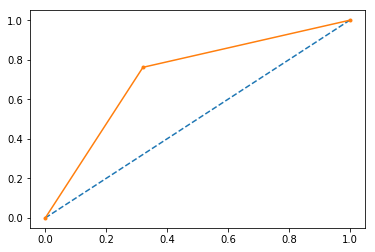

In [25]:
#Plotting the ROC Curve and the AUC

from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [26]:
#Features importance for logistic regression

d = {'Features': X.columns, 'Coefficients': [-1.05510761e-01,8.09700264e-04,  2.04298696e-01,  4.06016176e-02,
   1.41067574e-01,  8.74350634e-02,  6.12242051e-02, -8.31561265e-02,
  -9.82787875e-02, -1.05840968e-01, -4.28036654e-02, -2.04119756e-01,
   2.89975999e-01,  1.02632861e+00,  3.83911699e-01, -8.86662850e-01] }
feat_imp = pd.DataFrame(data=d)

feat_imp.reindex(feat_imp.Coefficients.abs().sort_values(ascending=False).index)

,Features,Coefficients
13,rushmorning_workday,1.026329
15,millenial,-0.886663
14,rushevening_workday,0.383912
12,workday,0.289976
2,Gender_male,0.204299
11,weekend,-0.204120
4,Tuesday,0.141068
9,Sunday,-0.105841
0,tripduration_minutes,-0.105511
8,Saturday,-0.098279
